Training data shape: (60000, 28, 28), Labels shape: (60000,)
Test data shape: (10000, 28, 28), Labels shape: (10000,)


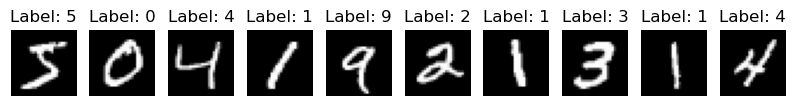

In [3]:
# Step 1: Load and Explore MNIST Data

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Check shape
print(f"Training data shape: {x_train.shape}, Labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Labels shape: {y_test.shape}")

# Display few sample images
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

In [4]:
# Data Type Information
print("Data type of training images:", x_train.dtype)
print("Data type of labels:", y_train.dtype)

# Min and Max pixel values
print("Minimum pixel value:", np.min(x_train))
print("Maximum pixel value:", np.max(x_train))

Data type of training images: uint8
Data type of labels: uint8
Minimum pixel value: 0
Maximum pixel value: 255


In [5]:
# Check if there are any missing values
print("Missing values in training images:", np.isnan(x_train).sum())
print("Missing values in training labels:", np.isnan(y_train).sum())

Missing values in training images: 0
Missing values in training labels: 0


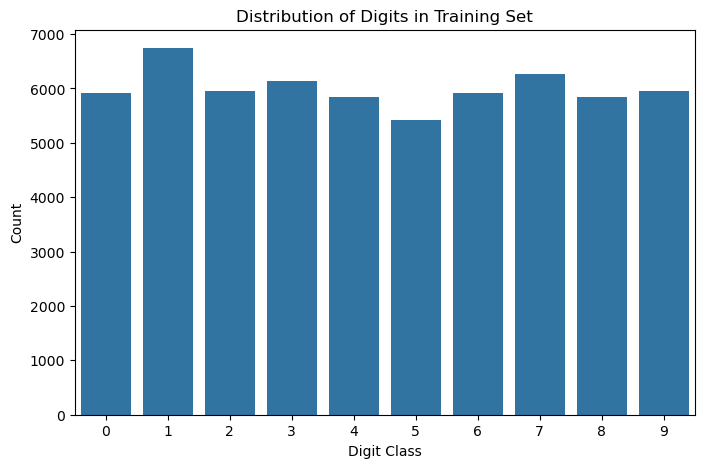

In [6]:
# Distribution of classes
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x=y_train)
plt.title("Distribution of Digits in Training Set")
plt.xlabel("Digit Class")
plt.ylabel("Count")
plt.show()

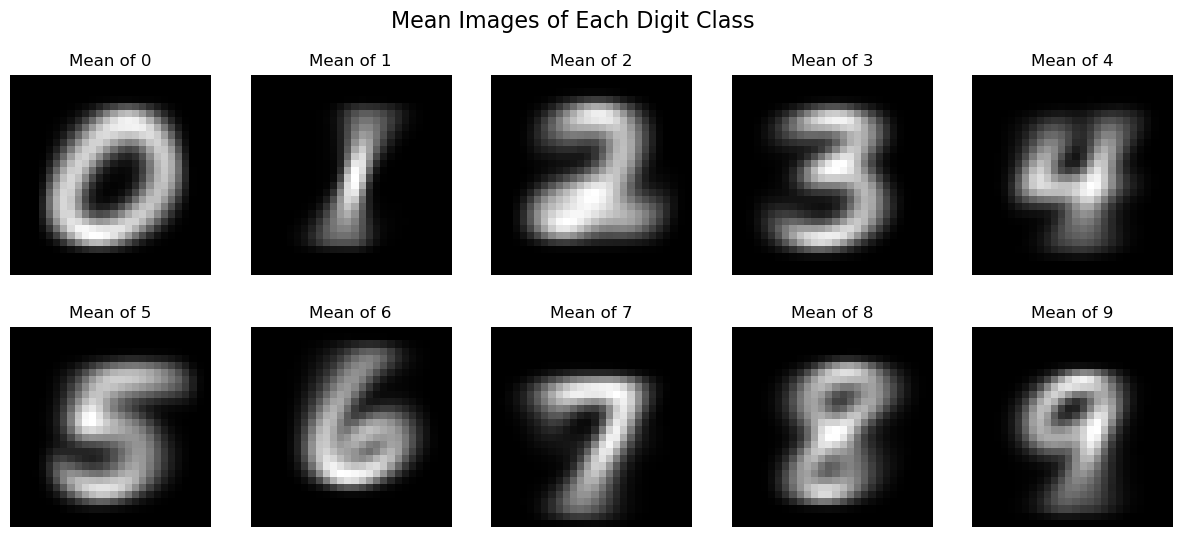

In [8]:
# Calculate the mean image for each digit
mean_images = []
for digit in range(10):
    mean_img = np.mean(x_train[y_train == digit], axis=0)
    mean_images.append(mean_img)

# Plot mean images
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(mean_images[i], cmap='gray')
    plt.title(f"Mean of {i}")
    plt.axis('off')
plt.suptitle('Mean Images of Each Digit Class', fontsize=16)
plt.show()

In [9]:
# Step 3.2: Encode Categorical Variables
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
y_train_ohe = to_categorical(y_train, num_classes=10)
y_test_ohe = to_categorical(y_test, num_classes=10)

print("Example one-hot encoding for label 3:", y_train_ohe[3])

Example one-hot encoding for label 3: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
# Step 3.3: Normalize Pixel Values
# Scale pixel values from [0, 255] to [0, 1]
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

# Reshape for CNN input (add channel dimension)
x_train_norm = x_train_norm[..., np.newaxis]  # shape (60000, 28, 28, 1)
x_test_norm = x_test_norm[..., np.newaxis]

print(f"New training data shape: {x_train_norm.shape}")
print(f"New test data shape: {x_test_norm.shape}")

New training data shape: (60000, 28, 28, 1)
New test data shape: (10000, 28, 28, 1)


In [13]:
# Step 3.4: Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=10,         # Rotate images by 10 degrees randomly
    width_shift_range=0.1,     # Shift images horizontally
    height_shift_range=0.1,    # Shift images vertically
    zoom_range=0.1             # Zoom into images randomly
)

# Fit the generator to training data
datagen.fit(x_train_norm)

In [14]:
# Step 4.1: Build the Advanced CNN Model

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model

# Residual Block
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

# Attention Block (Squeeze-and-Excitation)
def attention_block(x, reduction_ratio=8):
    filters = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // reduction_ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    x = layers.Multiply()([x, se])
    return x

# Dense Block (Mini DenseNet)
def dense_block(x, filters, kernel_size=3):
    x1 = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x2 = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(layers.Concatenate()([x, x1]))
    x3 = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(layers.Concatenate()([x, x1, x2]))
    return x3

# Full Model Definition
def build_custom_cnn(input_shape=(28,28,1), num_classes=10):
    inputs = Input(shape=input_shape)

    # Base CNN layers
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)

    # Residual Block (from paper)
    x = residual_block(x, filters=32)

    # Attention Block (Squeeze-and-Excitation from paper)
    x = attention_block(x)

    # Dense Block (like DenseNet, multi-layer feature combination)
    x = dense_block(x, filters=64)

    # Multi-path feature extraction (3x3 and 5x5 convolutions)
    path1 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(64, (5,5), padding='same', activation='relu')(x)
    x = layers.Concatenate()([path1, path2])

    # Pooling
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    # Additional Residual + Attention
    x = residual_block(x, filters=128)
    x = attention_block(x)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate model
model = build_custom_cnn()


In [15]:
# Step 4.2: Compile the Model

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Because we are using one-hot labels
    metrics=['accuracy']
)

# Print Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ conv2d_1[0][0],   │
│                     │ 32)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 28, 28,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        132 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 28, 28,    │          0 │ re_lu[0][0],      │
│                     │ 32)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,496 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ multiply[0][0],   │
│ (Concatenate)       │ 96)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     55,360 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28,    │          0 │ multiply[0][0],   │
│ (Concatenate)       │ 160)              │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     92,224 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 651,038 (2.48 MB)

 Trainable params: 651,038 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
# Step 4.2.5: Setup Callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 1. EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 2. ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# 3. ModelCheckpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [22]:
# Step 4.3: Trin the Model Using Data Augmentation

# Batch size and epochs
batch_size = 64
epochs = 20

# Training using ImageDataGenerator
history = model.fit(
    datagen.flow(x_train_norm, y_train_ohe, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test_norm, y_test_ohe),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9815 - loss: 0.0691
Epoch 1: val_accuracy improved from -inf to 0.99180, saving model to best_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 393s 419ms/step - accuracy: 0.9815 - loss: 0.0691 - val_accuracy: 0.9918 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9850 - loss: 0.0537
Epoch 2: val_accuracy did not improve from 0.99180
938/938 ━━━━━━━━━━━━━━━━━━━━ 391s 417ms/step - accuracy: 0.9850 - loss: 0.0537 - val_accuracy: 0.9877 - val_loss: 0.0397 - learning_rate: 0.0010
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9858 - loss: 0.0524
Epoch 3: val_accuracy improved from 0.99180 to 0.99200, saving model to best_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 598s 638ms/step - accuracy: 0.9858 - loss: 0.0523 - val_accuracy: 0.9920 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9872 - 

In [26]:
from tensorflow.keras.models import load_model

# Load the best saved model (best validation accuracy)
model = load_model('best_model.keras')

In [27]:
# Predict class probabilities on the normalized test set
y_pred_probs = model.predict(x_test_norm)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert true labels from one-hot encoding to class labels
y_true_classes = np.argmax(y_test_ohe, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step


In [31]:
from sklearn.metrics import classification_report

# Create the classification report
report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print the report to screen
print("===== Classification Report =====")
print(report)

# Save classification report to a text file
with open('classification_report.txt', 'w') as f:
    f.write(report)

print("\nClassification report saved as 'classification_report.txt'")

===== Classification Report =====
              precision    recall  f1-score   support

           0     0.9980    0.9980    0.9980       980
           1     0.9974    0.9991    0.9982      1135
           2     0.9990    0.9981    0.9985      1032
           3     0.9970    0.9970    0.9970      1010
           4     0.9959    0.9929    0.9944       982
           5     0.9933    0.9944    0.9938       892
           6     0.9969    0.9937    0.9953       958
           7     0.9990    0.9951    0.9971      1028
           8     0.9919    1.0000    0.9959       974
           9     0.9931    0.9931    0.9931      1009

    accuracy                         0.9962     10000
   macro avg     0.9961    0.9961    0.9961     10000
weighted avg     0.9962    0.9962    0.9962     10000


Classification report saved as 'classification_report.txt'


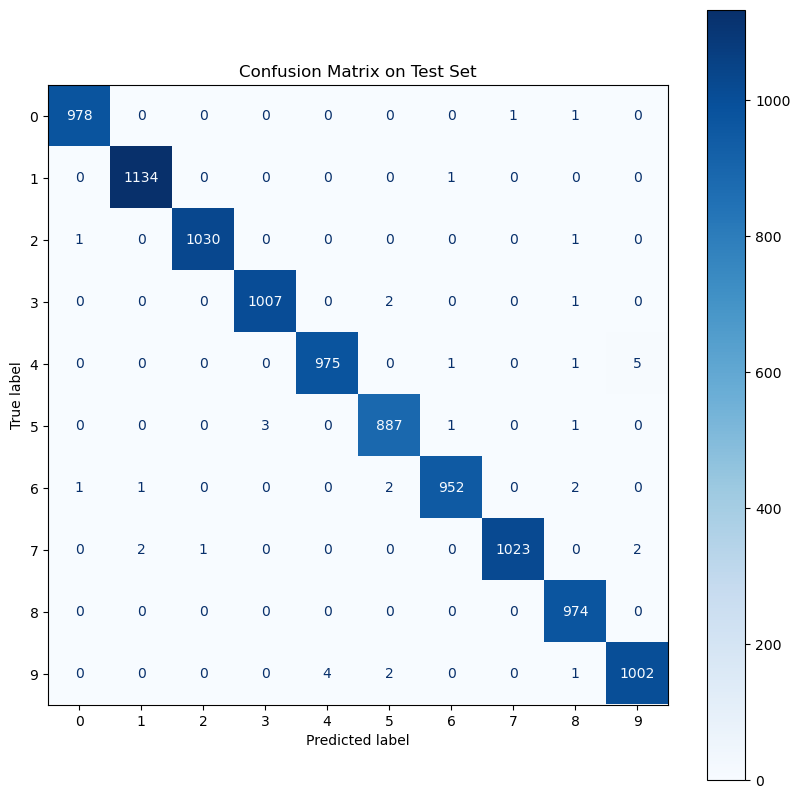

Confusion matrix saved as 'confusion_matrix.png' and displayed successfully.


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Step 1: Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Step 2: Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues)

# Step 3: Title
plt.title("Confusion Matrix on Test Set")

# Step 4: Save figure
plt.savefig('confusion_matrix.png')

# Step 5: Show figure (IMPORTANT)
plt.show()  # <--- Add this line to DISPLAY in notebook!

print("Confusion matrix saved as 'confusion_matrix.png' and displayed successfully.")

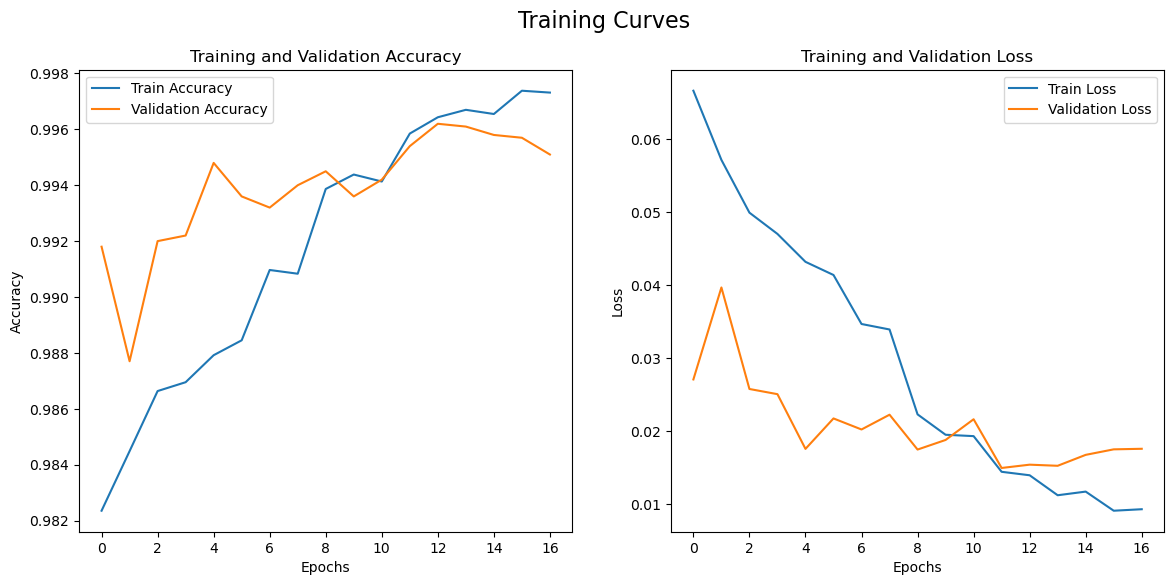

Training curves saved as 'training_curves.png' and displayed successfully.


In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 6.1: Convert History to DataFrame (Optional but nice)
history_df = pd.DataFrame(history.history)

# Step 6.2: Plot Training and Validation Accuracy & Loss

plt.figure(figsize=(14,6))

# Plot Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the figure
plt.suptitle('Training Curves', fontsize=16)
plt.savefig('training_curves.png')
plt.show()

print("Training curves saved as 'training_curves.png' and displayed successfully.")

In [36]:
from tensorflow.keras import layers, Model, Input

def build_generator():
    input_lr = Input(shape=(14, 14, 1))  # Low-Res input

    # Upsample
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_lr)
    x = layers.UpSampling2D(size=2)(x)  # 14x14 -> 28x28
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(x)  # Output 28x28x1

    return Model(input_lr, x, name="Generator")

In [39]:
def build_discriminator():
    input_hr = Input(shape=(28, 28, 1))  # High-Res input

    x = layers.Conv2D(64, (3,3), strides=2, padding='same')(input_hr)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    x = layers.Conv2D(128, (3,3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)  # Output: real/fake probability

    return Model(input_hr, x, name="Discriminator")

In [42]:
# Normalize MNIST data if not already done
x_train = x_train / 255.0

# High-Res images (original 28x28)
x_train_hr = np.expand_dims(x_train, axis=-1)  # add channel dimension

# Low-Res images (downsampled 14x14)
x_train_lr = tf.image.resize(x_train_hr, (14,14)).numpy()  # resize and convert back to numpy

In [44]:
# Instantiate models
generator = build_generator()
discriminator = build_discriminator()

# Losses and optimizers
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training parameters
num_epochs = 10
batch_size = 32

# Create dataset (pair low-res, high-res)
dataset = tf.data.Dataset.from_tensor_slices((x_train_lr, x_train_hr))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Training Loop
for epoch in range(1, num_epochs + 1):
    batch_idx = 0
    for batch_lr, batch_hr in dataset:
        
        # 1. Train Discriminator
        with tf.GradientTape() as tape:
            fake_hr = generator(batch_lr, training=True)
            real_output = discriminator(batch_hr, training=True)
            fake_output = discriminator(fake_hr, training=True)
            
            disc_loss_real = binary_crossentropy(tf.ones_like(real_output), real_output)
            disc_loss_fake = binary_crossentropy(tf.zeros_like(fake_output), fake_output)
            disc_loss = disc_loss_real + disc_loss_fake
        
        grads = tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

        # 2. Train Generator
        with tf.GradientTape() as tape:
            fake_hr = generator(batch_lr, training=True)
            fake_output = discriminator(fake_hr, training=True)

            adversarial_loss = binary_crossentropy(tf.ones_like(fake_output), fake_output)
            pixel_loss = mse(batch_hr, fake_hr)
            gen_loss = adversarial_loss + 0.001 * pixel_loss

        grads = tape.gradient(gen_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}: Gen Loss = {gen_loss.numpy():.4f}, Disc Loss = {disc_loss.numpy():.4f}")
        
        batch_idx += 1

    # End of Epoch Summary
    print(f"End of Epoch {epoch}: Generator Loss = {gen_loss.numpy():.4f}, Discriminator Loss = {disc_loss.numpy():.4f}\n")

Epoch 1, Batch 0: Gen Loss = 0.6968, Disc Loss = 1.3770
Epoch 1, Batch 100: Gen Loss = 2.6439, Disc Loss = 0.1727
Epoch 1, Batch 200: Gen Loss = 1.2800, Disc Loss = 0.8143
Epoch 1, Batch 300: Gen Loss = 0.9711, Disc Loss = 0.9403
Epoch 1, Batch 400: Gen Loss = 0.7054, Disc Loss = 1.2930
Epoch 1, Batch 500: Gen Loss = 1.1176, Disc Loss = 1.0086
Epoch 1, Batch 600: Gen Loss = 0.9842, Disc Loss = 1.4209
Epoch 1, Batch 700: Gen Loss = 0.8491, Disc Loss = 1.1101
Epoch 1, Batch 800: Gen Loss = 0.8320, Disc Loss = 1.2368
Epoch 1, Batch 900: Gen Loss = 0.8451, Disc Loss = 1.2243
Epoch 1, Batch 1000: Gen Loss = 0.8283, Disc Loss = 1.2569
Epoch 1, Batch 1100: Gen Loss = 0.8117, Disc Loss = 1.3130
Epoch 1, Batch 1200: Gen Loss = 0.7790, Disc Loss = 1.2959
Epoch 1, Batch 1300: Gen Loss = 0.7731, Disc Loss = 1.3035
Epoch 1, Batch 1400: Gen Loss = 0.6355, Disc Loss = 1.3743
Epoch 1, Batch 1500: Gen Loss = 0.7085, Disc Loss = 1.3350
Epoch 1, Batch 1600: Gen Loss = 0.6669, Disc Loss = 1.3731
Epoch 1, 

2025-04-27 10:36:24.304442: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


End of Epoch 1: Generator Loss = 0.5380, Discriminator Loss = 1.5352

Epoch 2, Batch 0: Gen Loss = 0.5966, Disc Loss = 1.5094
Epoch 2, Batch 100: Gen Loss = 1.0747, Disc Loss = 1.1316
Epoch 2, Batch 200: Gen Loss = 0.9138, Disc Loss = 1.4146
Epoch 2, Batch 300: Gen Loss = 0.6145, Disc Loss = 1.3558
Epoch 2, Batch 400: Gen Loss = 0.7650, Disc Loss = 1.3170
Epoch 2, Batch 500: Gen Loss = 0.7801, Disc Loss = 1.3222
Epoch 2, Batch 600: Gen Loss = 0.6823, Disc Loss = 1.3766
Epoch 2, Batch 700: Gen Loss = 0.8656, Disc Loss = 1.1835
Epoch 2, Batch 800: Gen Loss = 0.8293, Disc Loss = 1.4471
Epoch 2, Batch 900: Gen Loss = 0.5245, Disc Loss = 1.4998
Epoch 2, Batch 1000: Gen Loss = 0.9801, Disc Loss = 1.1014
Epoch 2, Batch 1100: Gen Loss = 0.7959, Disc Loss = 1.3055
Epoch 2, Batch 1200: Gen Loss = 0.7312, Disc Loss = 1.4028
Epoch 2, Batch 1300: Gen Loss = 0.9368, Disc Loss = 1.3266
Epoch 2, Batch 1400: Gen Loss = 0.7310, Disc Loss = 1.1883
Epoch 2, Batch 1500: Gen Loss = 0.8063, Disc Loss = 1.216

2025-04-27 10:40:51.717507: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


End of Epoch 2: Generator Loss = 0.6778, Discriminator Loss = 1.2252

Epoch 3, Batch 0: Gen Loss = 0.7343, Disc Loss = 1.2036
Epoch 3, Batch 100: Gen Loss = 0.7789, Disc Loss = 1.3457
Epoch 3, Batch 200: Gen Loss = 0.8749, Disc Loss = 1.2526
Epoch 3, Batch 300: Gen Loss = 0.8198, Disc Loss = 1.3138
Epoch 3, Batch 400: Gen Loss = 0.7626, Disc Loss = 1.2601
Epoch 3, Batch 500: Gen Loss = 0.8605, Disc Loss = 1.2891
Epoch 3, Batch 600: Gen Loss = 0.8570, Disc Loss = 1.3558
Epoch 3, Batch 700: Gen Loss = 0.7467, Disc Loss = 1.1742
Epoch 3, Batch 800: Gen Loss = 0.7366, Disc Loss = 1.4116
Epoch 3, Batch 900: Gen Loss = 0.8675, Disc Loss = 1.2151
Epoch 3, Batch 1000: Gen Loss = 0.8111, Disc Loss = 1.2236
Epoch 3, Batch 1100: Gen Loss = 0.5948, Disc Loss = 1.4111
Epoch 3, Batch 1200: Gen Loss = 0.9331, Disc Loss = 1.2747
Epoch 3, Batch 1300: Gen Loss = 0.8827, Disc Loss = 1.2326
Epoch 3, Batch 1400: Gen Loss = 0.6808, Disc Loss = 1.4078
Epoch 3, Batch 1500: Gen Loss = 0.8473, Disc Loss = 1.199

2025-04-27 10:49:48.495139: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


End of Epoch 4: Generator Loss = 0.6067, Discriminator Loss = 1.4767

Epoch 5, Batch 0: Gen Loss = 0.6990, Disc Loss = 1.4552
Epoch 5, Batch 100: Gen Loss = 0.8614, Disc Loss = 1.2915
Epoch 5, Batch 200: Gen Loss = 0.7999, Disc Loss = 1.2027
Epoch 5, Batch 300: Gen Loss = 0.8918, Disc Loss = 1.2492
Epoch 5, Batch 400: Gen Loss = 0.8559, Disc Loss = 1.2336
Epoch 5, Batch 500: Gen Loss = 0.6992, Disc Loss = 1.4603
Epoch 5, Batch 600: Gen Loss = 0.8412, Disc Loss = 1.3271
Epoch 5, Batch 700: Gen Loss = 0.5874, Disc Loss = 1.3685
Epoch 5, Batch 800: Gen Loss = 0.9013, Disc Loss = 1.2447
Epoch 5, Batch 900: Gen Loss = 0.7866, Disc Loss = 1.1727
Epoch 5, Batch 1000: Gen Loss = 0.9873, Disc Loss = 1.2065
Epoch 5, Batch 1100: Gen Loss = 0.8931, Disc Loss = 1.2326
Epoch 5, Batch 1200: Gen Loss = 1.0654, Disc Loss = 1.1594
Epoch 5, Batch 1300: Gen Loss = 0.7946, Disc Loss = 1.1581
Epoch 5, Batch 1400: Gen Loss = 0.9973, Disc Loss = 1.1141
Epoch 5, Batch 1500: Gen Loss = 0.8253, Disc Loss = 1.162

2025-04-27 11:07:43.044761: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


End of Epoch 8: Generator Loss = 0.9263, Discriminator Loss = 1.1673

Epoch 9, Batch 0: Gen Loss = 0.9325, Disc Loss = 1.1616
Epoch 9, Batch 100: Gen Loss = 0.6694, Disc Loss = 1.4815
Epoch 9, Batch 200: Gen Loss = 0.8940, Disc Loss = 1.2486
Epoch 9, Batch 300: Gen Loss = 0.8605, Disc Loss = 1.2769
Epoch 9, Batch 400: Gen Loss = 0.8230, Disc Loss = 1.2104
Epoch 9, Batch 500: Gen Loss = 0.8232, Disc Loss = 1.2515
Epoch 9, Batch 600: Gen Loss = 0.7988, Disc Loss = 1.3267
Epoch 9, Batch 700: Gen Loss = 0.9001, Disc Loss = 1.2364
Epoch 9, Batch 800: Gen Loss = 0.8137, Disc Loss = 1.2956
Epoch 9, Batch 900: Gen Loss = 0.8219, Disc Loss = 1.2712
Epoch 9, Batch 1000: Gen Loss = 0.8734, Disc Loss = 1.4014
Epoch 9, Batch 1100: Gen Loss = 0.8850, Disc Loss = 1.2305
Epoch 9, Batch 1200: Gen Loss = 0.7926, Disc Loss = 1.2707
Epoch 9, Batch 1300: Gen Loss = 0.8425, Disc Loss = 1.2634
Epoch 9, Batch 1400: Gen Loss = 0.7083, Disc Loss = 1.2688
Epoch 9, Batch 1500: Gen Loss = 0.7971, Disc Loss = 1.316

In [47]:
generator.save('simple_srgan_generator.keras')
print("Generator model saved successfully in Keras format (.keras)!")

Generator model saved successfully in Keras format (.keras)!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


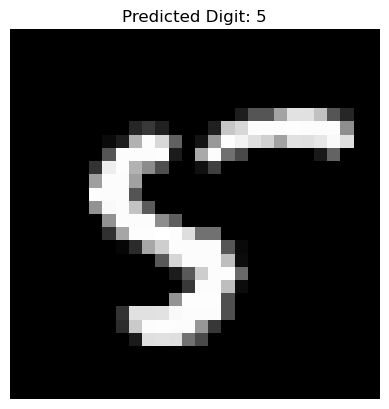

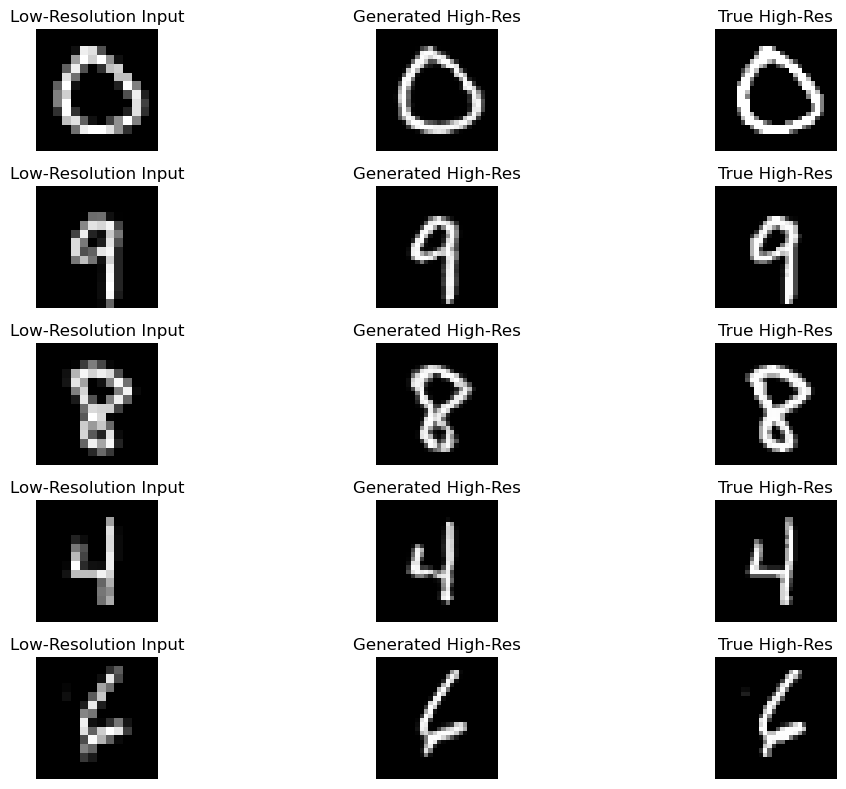

In [48]:
# Select a few random test samples
num_samples = 5
indices = np.random.choice(len(x_train_lr), num_samples, replace=False)

low_res_examples = x_train_lr[indices]
high_res_examples = x_train_hr[indices]

# Generate Super-Resolved images
generated_hr = generator.predict(low_res_examples)

# Plot
plt.figure(figsize=(12, 8))
for i in range(num_samples):
    # Low-Resolution Input
    plt.subplot(num_samples, 3, 3*i + 1)
    plt.imshow(low_res_examples[i].squeeze(), cmap='gray')
    plt.title('Low-Resolution Input')
    plt.axis('off')
    
    # Generated High-Resolution
    plt.subplot(num_samples, 3, 3*i + 2)
    plt.imshow(generated_hr[i].squeeze(), cmap='gray')
    plt.title('Generated High-Res')
    plt.axis('off')
    
    # Ground Truth High-Resolution
    plt.subplot(num_samples, 3, 3*i + 3)
    plt.imshow(high_res_examples[i].squeeze(), cmap='gray')
    plt.title('True High-Res')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Build a simple CNN model
classifier = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes
])

# Compile the model
classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Train the model
classifier.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Save the model
classifier.save('mnist_classifier.keras')

print("Classifier model trained and saved as 'mnist_classifier.keras'")

Epoch 1/5


/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8849 - loss: 0.3804 - val_accuracy: 0.9842 - val_loss: 0.0567
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9824 - loss: 0.0543 - val_accuracy: 0.9887 - val_loss: 0.0408
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9888 - loss: 0.0371 - val_accuracy: 0.9895 - val_loss: 0.0355
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9925 - loss: 0.0235 - val_accuracy: 0.9903 - val_loss: 0.0379
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9938 - loss: 0.0186 - val_accuracy: 0.9893 - val_loss: 0.0395
Classifier model trained and saved as 'mnist_classifier.keras'


In [110]:
import gradio as gr
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model

# --- Load Models ---
model = load_model('best_model.keras')

# --- Load MNIST Test Data ---
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test_norm = x_test / 255.0
x_test_norm = np.expand_dims(x_test_norm, axis=-1)  # shape (28,28,1)
y_true_classes = y_test

# --- Select Random Test Samples ---
num_images = 50
indices = np.random.choice(len(x_test_norm), num_images, replace=False)
test_images = x_test_norm[indices]
test_labels = y_true_classes[indices]

# Create Dropdown Options
image_options = {f"Image {i} (True: {test_labels[i]})": i for i in range(num_images)}

# --- Grad-CAM Overlay ---
def generate_gradcam_overlay(img_array, model):
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break
    if last_conv_layer_name is None:
        return np.zeros((280, 280, 3))  # fallback blank

    grad_model = tf.keras.models.Model([model.inputs], 
                                       [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    # Resize and Colorize
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (280, 280)).numpy()
    heatmap = np.squeeze(heatmap)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    original_img = tf.image.resize(img_array[0], (280, 280)).numpy()
    if original_img.shape[-1] == 1:
        original_img = np.repeat(original_img, 3, axis=-1)

    original_img = np.clip(original_img * 255.0, 0, 255).astype(np.uint8)

    overlay = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)
    return overlay

# --- Prediction Helper ---
def run_prediction(image):
    img_batch = np.expand_dims(image, axis=0)
    prediction = model.predict(img_batch, verbose=0)[0]

    top3_indices = np.argsort(prediction)[-3:][::-1]
    top3_probs = prediction[top3_indices]

    top3_text = "\n".join([f"Digit {i}: {p*100:.2f}%" for i, p in zip(top3_indices, top3_probs)])

    resized_img = tf.image.resize(image, size=(140, 140)).numpy()

    gradcam_overlay = generate_gradcam_overlay(img_batch, model)

    return (
        image.squeeze(),          # Original (28x28)
        resized_img.squeeze(),    # Upscaled (140x140)
        gradcam_overlay,          # GradCAM overlay
        top3_text                 # Top-3 predictions
    )

# --- Dropdown Prediction ---
def predict_from_dropdown(selected_img_name):
    index = image_options[selected_img_name]
    selected_img = test_images[index]
    return run_prediction(selected_img)

# --- Upload Prediction ---
def predict_from_upload(uploaded_img):
    if uploaded_img is None:
        return None, None, None, "No image uploaded."

    # Debug print
    print(f"Type of uploaded_img: {type(uploaded_img)}")

    if isinstance(uploaded_img, dict):
        # Newer Gradio sometimes wraps uploads as dict {'name', 'mime_type', 'size', 'array'}
        uploaded_img = uploaded_img.get('array', None)
        if uploaded_img is None:
            return None, None, None, "Error reading uploaded image."

    uploaded_img = np.array(uploaded_img)

    # Now handle if RGB (3 channels) or Grayscale
    if uploaded_img.ndim == 3:
        if uploaded_img.shape[-1] == 3:
            uploaded_img = tf.image.rgb_to_grayscale(uploaded_img).numpy()
    if uploaded_img.ndim == 2:
        uploaded_img = np.expand_dims(uploaded_img, axis=-1)

    uploaded_img = uploaded_img.astype(np.float32) / 255.0
    uploaded_img = tf.image.resize(uploaded_img, (28, 28)).numpy()
    uploaded_img = np.clip(uploaded_img, 0, 1)

    return run_prediction(uploaded_img)

# def predict_from_upload(uploaded_img):
#     if uploaded_img is None:
#         return None, None, None, "No image uploaded."

#     # DEBUGGING FIRST
#     print("\n\n=== DEBUGGING UPLOADED IMAGE ===")
#     print(f"Type: {type(uploaded_img)}")
#     if isinstance(uploaded_img, dict):
#         print("Uploaded image is a dict.")
#         uploaded_img = uploaded_img.get('array', None)
#     print(f"Shape after extraction: {uploaded_img.shape if hasattr(uploaded_img, 'shape') else 'no shape'}")
#     print("=== END DEBUGGING ===\n\n")

#     if uploaded_img is None:
#         return None, None, None, "Error reading uploaded image."

#     uploaded_img = np.array(uploaded_img)

#     # Handle if 3-channel RGB
#     if uploaded_img.ndim == 3 and uploaded_img.shape[-1] == 3:
#         uploaded_img = tf.image.rgb_to_grayscale(uploaded_img).numpy()

#     if uploaded_img.ndim == 2:
#         uploaded_img = np.expand_dims(uploaded_img, axis=-1)

#     uploaded_img = uploaded_img.astype(np.float32) / 255.0
#     uploaded_img = tf.image.resize(uploaded_img, (28, 28)).numpy()
#     uploaded_img = np.clip(uploaded_img, 0, 1)

#     return run_prediction(uploaded_img)

# --- Build Gradio App ---
with gr.Blocks(theme=gr.themes.Soft()) as app:
    gr.Markdown(
        """
        # MNIST Digit Recognition Demo
        Select a test image or upload your own blurry digit image.
        Displays: Top-3 Predictions + Grad-CAM Attention Overlay!
        """
    )

    with gr.Tabs():
        with gr.Tab("Select Test Image"):
            dropdown = gr.Dropdown(choices=list(image_options.keys()), label="Select a Test Image")
            predict_btn = gr.Button("Predict from Selected Image", variant="primary")

            outputs = [
                gr.Image(label="Original Image (28x28)", height=400, width=400),
                gr.Image(label="Upscaled Image (140x140)", height=400, width=400),
                gr.Image(label="Grad-CAM Overlay", height=400, width=400),
                gr.Label(label="Top-3 Predictions")
            ]

            predict_btn.click(
                predict_from_dropdown,
                inputs=dropdown,
                outputs=outputs
            )

        with gr.Tab("Upload Your Own Image"):
            uploader = gr.Image(type="numpy", label="Upload a Grayscale Digit Image")
            upload_btn = gr.Button("Predict from Uploaded Image", variant="primary")

            upload_btn.click(
                predict_from_upload,
                inputs=uploader,
                outputs=outputs
            )

app.launch()

/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 36 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


* Running on local URL:  http://127.0.0.1:7916

To create a public link, set `share=True` in `launch()`.


In [106]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf

# Step 1: Load Models
generator = load_model('simple_srgan_generator.keras')
classifier = load_model('mnist_classifier.keras')

# Step 2: Load and Prepare Test Images
(x_test, y_test), _ = tf.keras.datasets.mnist.load_data()

# Normalize and expand dims
x_test = x_test / 255.0
x_test = np.expand_dims(x_test, axis=-1)  # shape (28,28,1)

# Create low-res images
x_test_hr = x_test
x_test_lr = tf.image.resize(x_test_hr, (14, 14)).numpy()

# Select 50 random samples
num_samples = 50
indices = np.random.choice(len(x_test_lr), num_samples, replace=False)

low_res_samples = x_test_lr[indices]
high_res_samples = x_test_hr[indices]
true_labels = y_test[indices]

# Step 3: Define Prediction Function
def super_resolve_and_predict(image_index):
    lr_image = low_res_samples[image_index]

    # Super-resolve
    sr_image = generator.predict(np.expand_dims(lr_image, axis=0))[0]

    # Predict digit
    prediction_probs = classifier.predict(np.expand_dims(sr_image, axis=0))
    predicted_digit = np.argmax(prediction_probs)

    return (
        lr_image.squeeze(),
        sr_image.squeeze(),
        f"Predicted Digit: {predicted_digit}"
    )

# Step 4: Create Dropdown Options
dropdown_choices = [f"Image {i} (True: {true_labels[i]})" for i in range(num_samples)]

# Step 5: Build Gradio App
dropdown = gr.Dropdown(choices=dropdown_choices, label="Select a Test Image")

app = gr.Interface(
    fn=lambda img_name: super_resolve_and_predict(int(img_name.split()[1])),
    inputs=dropdown,
    outputs=[
        gr.Image(label="Low-Resolution Image (14x14)"),
        gr.Image(label="Super-Resolved Image (28x28)"),
        gr.Label(label="Predicted Digit")
    ],
    title="MNIST Super-Resolution & Digit Prediction",
    description="Select a low-res test image ➔ super-resolve it ➔ predict the digit."
)

app.launch()

* Running on local URL:  http://127.0.0.1:7912

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [105]:
import gradio as gr
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model

# Step 1: Load Models
generator = load_model('simple_srgan_generator.keras')
classifier = load_model('mnist_classifier.keras')

# Dummy call to build the classifier properly (very important!)
dummy_input = tf.zeros((1, 28, 28, 1))
classifier(dummy_input)

# Step 2: Load and Prepare Test Images
(x_test, y_test), _ = tf.keras.datasets.mnist.load_data()

# Normalize and expand dims
x_test = x_test / 255.0
x_test = np.expand_dims(x_test, axis=-1)  # shape (28,28,1)

# Create low-res images
x_test_hr = x_test
x_test_lr = tf.image.resize(x_test_hr, (14, 14)).numpy()

# Select 50 random samples
num_samples = 50
indices = np.random.choice(len(x_test_lr), num_samples, replace=False)

low_res_samples = x_test_lr[indices]
high_res_samples = x_test_hr[indices]
true_labels = y_test[indices]

# Step 3: GradCAM Overlay Function
def generate_gradcam_overlay(img_array, classifier_model):
    last_conv_layer = None
    for layer in reversed(classifier_model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break
    if last_conv_layer is None:
        return np.zeros((280, 280, 3))

    # Build grad_model properly
    grad_model = tf.keras.models.Model(
        inputs=classifier_model.input,
        outputs=[last_conv_layer.output, classifier_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (280, 280)).numpy()
    heatmap = np.squeeze(heatmap)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    original_img = tf.image.resize(img_array[0], (280, 280)).numpy()
    if original_img.shape[-1] == 1:
        original_img = np.repeat(original_img, 3, axis=-1)
    original_img = np.clip(original_img * 255.0, 0, 255).astype(np.uint8)

    overlay = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)
    return overlay

# Step 4: Super-Resolve and Predict
def super_resolve_and_predict(image_index):
    lr_image = low_res_samples[image_index]

    # Super-resolve
    sr_image = generator.predict(np.expand_dims(lr_image, axis=0))[0]

    # Predict
    prediction_probs = classifier.predict(np.expand_dims(sr_image, axis=0))[0]
    top3_indices = np.argsort(prediction_probs)[-3:][::-1]
    top3_probs = prediction_probs[top3_indices]

    top3_text = "\n".join([f"Digit {i}: {p*100:.2f}%" for i, p in zip(top3_indices, top3_probs)])

    # GradCAM
    gradcam_overlay = generate_gradcam_overlay(np.expand_dims(sr_image, axis=0), classifier)

    return (
        lr_image.squeeze(),         # Low-resolution (14x14)
        sr_image.squeeze(),          # Super-resolved (28x28)
        gradcam_overlay,             # GradCAM Overlay
        top3_text                    # Top-3 Predictions
    )

# Step 5: Create Dropdown Options
dropdown_choices = [f"Image {i} (True: {true_labels[i]})" for i in range(num_samples)]

# Step 6: Build Gradio App
with gr.Blocks(theme=gr.themes.Soft()) as app:
    gr.Markdown(
        """
        # MNIST Super-Resolution and Digit Prediction
        Select a blurry low-res image ➔ See super-resolved version ➔ View top-3 predictions ➔ Visualize Grad-CAM attention!
        """
    )

    dropdown = gr.Dropdown(choices=dropdown_choices, label="Select a Test Image")
    predict_btn = gr.Button("Predict")

    outputs = [
        gr.Image(label="Low-Resolution Image (14x14)", height=280, width=280),
        gr.Image(label="Super-Resolved Image (28x28)", height=280, width=280),
        gr.Image(label="Grad-CAM Attention Overlay", height=280, width=280),
        gr.Label(label="Top-3 Predictions")
    ]

    predict_btn.click(
        lambda img_name: super_resolve_and_predict(int(img_name.split()[1])),
        inputs=dropdown,
        outputs=outputs
    )

app.launch()

* Running on local URL:  http://127.0.0.1:7911

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/gradio/blocks.py", line 2136, in process_api
    result = await self.call_function(
  File "/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/gradio/blocks.py", line 1662, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 2461, in run_sync_in_worker_thread
    re